# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [271]:
import json

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [8]:
!pwd

/workspace/lectures/spark/notebooks


In [21]:
!ls /workspace/data/ml-25m/

genome-scores.csv  links.csv	      movies.csv   README.txt  tmdb.json
genome-tags.csv    ml-25m-README.htm  ratings.csv  tags.csv


In [23]:
!hdfs dfs -ls 'file:///workspace/data/ml-25m/'

Found 9 items
-rw-rw-r--   1 1000 1000      10460 2019-11-21 13:41 file:///workspace/data/ml-25m/README.txt
-rw-r--r--   1 1000 1000  435164157 2020-01-12 18:37 file:///workspace/data/ml-25m/genome-scores.csv
-rw-r--r--   1 1000 1000      18103 2020-01-12 18:37 file:///workspace/data/ml-25m/genome-tags.csv
-rw-r--r--   1 1000 1000    1368578 2020-01-12 18:37 file:///workspace/data/ml-25m/links.csv
-rw-r--r--   1 1000 1000      12022 2020-01-10 20:42 file:///workspace/data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 1000 1000    3038099 2020-01-12 18:37 file:///workspace/data/ml-25m/movies.csv
-rw-r--r--   1 1000 1000  678260987 2020-01-12 18:37 file:///workspace/data/ml-25m/ratings.csv
-rw-r--r--   1 1000 1000   38810332 2020-01-12 18:37 file:///workspace/data/ml-25m/tags.csv
-rw-r--r--   1 1000 1000  404281742 2020-01-12 18:37 file:///workspace/data/ml-25m/tmdb.json


In [25]:
!hdfs dfs -copyFromLocal 'file:///workspace/data' .

### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [265]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [27]:
ratings = sc.textFile(RATINGS_PATH)

In [28]:
%%time
ratings.take(5)

CPU times: user 3.81 ms, sys: 6.22 ms, total: 10 ms
Wall time: 2.15 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [29]:
ratings.getNumPartitions()

5

In [30]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [31]:
ratings.count()

25000095

Количество пользователей

In [32]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 30.5 ms, sys: 10.1 ms, total: 40.6 ms
Wall time: 1min 20s


162541

Сохраним датасет в память

In [33]:
ratings = ratings.persist()

In [34]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 18.4 ms, sys: 13.7 ms, total: 32.1 ms
Wall time: 2min 11s


162541

Количество фильмов

In [35]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 14.9 ms, sys: 4.14 ms, total: 19.1 ms
Wall time: 37.2 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [63]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [58]:
ratings.map(lambda r: (r.movie_id, (r.rating, 1))).take(10)

[(296, (5.0, 1)),
 (306, (3.5, 1)),
 (307, (5.0, 1)),
 (665, (5.0, 1)),
 (899, (3.5, 1)),
 (1088, (4.0, 1)),
 (1175, (3.5, 1)),
 (1217, (3.5, 1)),
 (1237, (5.0, 1)),
 (1250, (4.0, 1))]

In [59]:
ratings.map(lambda r: (r.movie_id, (r.rating, 1))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).take(10)

[(32770, (589.5, 165)),
 (5, (35826.5, 11714)),
 (196615, (3.5, 1)),
 (131080, (291.0, 97)),
 (10, (96707.5, 28265)),
 (15, (7504.5, 2760)),
 (131090, (5.5, 2)),
 (20, (11020.5, 3840)),
 (98325, (9.5, 3)),
 (25, (73803.5, 20070))]

In [60]:
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]).take(10)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516),
 (15, 2.7190217391304348),
 (131090, 2.75),
 (20, 2.869921875),
 (98325, 3.1666666666666665),
 (25, 3.677304434479322)]

In [64]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (175077, (5.0, ['175077', 'Fatal Call (2012)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [70]:
!hdfs dfs -ls 'file:///workspace/data/ml-25m/'

Found 9 items
-rw-rw-r--   1 1000 1000      10460 2019-11-21 13:41 file:///workspace/data/ml-25m/README.txt
-rw-r--r--   1 1000 1000  435164157 2020-01-12 18:37 file:///workspace/data/ml-25m/genome-scores.csv
-rw-r--r--   1 1000 1000      18103 2020-01-12 18:37 file:///workspace/data/ml-25m/genome-tags.csv
-rw-r--r--   1 1000 1000    1368578 2020-01-12 18:37 file:///workspace/data/ml-25m/links.csv
-rw-r--r--   1 1000 1000      12022 2020-01-10 20:42 file:///workspace/data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 1000 1000    3038099 2020-01-12 18:37 file:///workspace/data/ml-25m/movies.csv
-rw-r--r--   1 1000 1000  678260987 2020-01-12 18:37 file:///workspace/data/ml-25m/ratings.csv
-rw-r--r--   1 1000 1000   38810332 2020-01-12 18:37 file:///workspace/data/ml-25m/tags.csv
-rw-r--r--   1 1000 1000  404281742 2020-01-12 18:37 file:///workspace/data/ml-25m/tmdb.json


In [71]:
os.path.join(DATA_PATH, 'movie_avg_rating')

'data/ml-25m/movie_avg_rating'

In [ ]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [72]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 13:11 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58962 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112506 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131450 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114305 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133476 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117792 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143092 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167639 2021-02-17 13:11 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [73]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [74]:
tags\
    .map(lambda s: (s.split(',')[2], 1)).take(10)

[('tag', 1),
 ('classic', 1),
 ('sci-fi', 1),
 ('dark comedy', 1),
 ('great dialogue', 1),
 ("so bad it's good", 1),
 ('unreliable narrators', 1),
 ('tense', 1),
 ('artificial intelligence', 1),
 ('philosophical', 1)]

In [75]:
tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b).take(10)

[('Sam Fell', 3),
 ('Charlie Sheen', 68),
 ('reminiscence', 1),
 ('Sign language', 3),
 ('biological attack', 2),
 ('salvador dalí', 1),
 ('thalassophobia', 1),
 ('stb', 1),
 ('space opera', 346),
 ('cell mate', 2)]

In [77]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [78]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

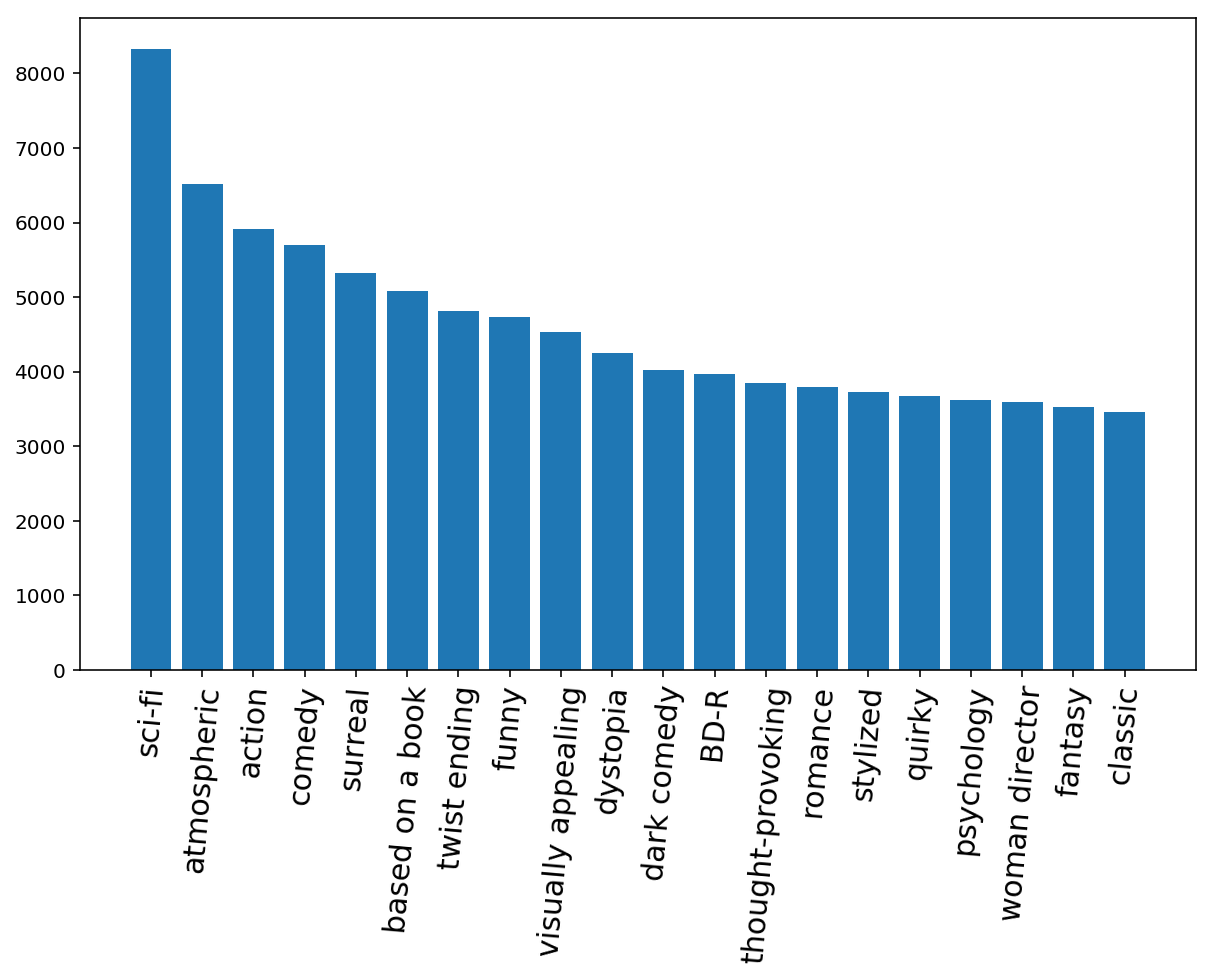

In [79]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [85]:
ratings = sc.textFile(RATINGS_PATH)

In [88]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [95]:
movies = sc.textFile(MOVIES_PATH)

In [96]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [90]:
ratings.map(lambda r: (r.movie_id, 1)).take(10)

[(296, 1),
 (306, 1),
 (307, 1),
 (665, 1),
 (899, 1),
 (1088, 1),
 (1175, 1),
 (1217, 1),
 (1237, 1),
 (1250, 1)]

In [92]:
ratings.map(lambda r: (r.movie_id, 1)).reduceByKey(lambda a, b: a + b).take(10)

[(32770, 165),
 (5, 11714),
 (196615, 1),
 (131080, 97),
 (10, 28265),
 (15, 2760),
 (131090, 2),
 (20, 3840),
 (98325, 3),
 (25, 20070)]

In [108]:
num_ratings = ratings.map(lambda r: (r.movie_id, 1)).reduceByKey(lambda a, b: a + b)

In [109]:
num_ratings.take(10)

[(32770, 165),
 (5, 11714),
 (196615, 1),
 (131080, 97),
 (10, 28265),
 (15, 2760),
 (131090, 2),
 (20, 3840),
 (98325, 3),
 (25, 20070)]

In [112]:
num_ratings.sortBy(lambda x: x[1], ascending=False).take(10)

[(356, 81491),
 (318, 81482),
 (296, 79672),
 (593, 74127),
 (2571, 72674),
 (260, 68717),
 (480, 64144),
 (527, 60411),
 (110, 59184),
 (2959, 58773)]

In [114]:
num_ratings \
    .join(movies) \
    .sortBy(lambda x: x[1], ascending=False)\
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

**фильмы с наибольшим числом оценок**

In [118]:
num_ratings \
    .join(movies) \
    .sortBy(lambda x: x[1], ascending=False)\
    .map(lambda r: (r[1][1][1], r[1][0]))\
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [134]:
ratings.map(lambda r: (r.movie_id, (r.rating, 1))).take(10)

[(296, (5.0, 1)),
 (306, (3.5, 1)),
 (307, (5.0, 1)),
 (665, (5.0, 1)),
 (899, (3.5, 1)),
 (1088, (4.0, 1)),
 (1175, (3.5, 1)),
 (1217, (3.5, 1)),
 (1237, (5.0, 1)),
 (1250, (4.0, 1))]

In [138]:
ratings\
    .map(lambda r: (r.movie_id, (r.rating, 1)))\
    .filter(lambda triple: triple[1][0] == 5.0)\
    .take(10)

[(296, (5.0, 1)),
 (307, (5.0, 1)),
 (665, (5.0, 1)),
 (1237, (5.0, 1)),
 (2632, (5.0, 1)),
 (2692, (5.0, 1)),
 (3569, (5.0, 1)),
 (3949, (5.0, 1)),
 (4144, (5.0, 1)),
 (4325, (5.0, 1))]

In [145]:
ratings\
    .map(lambda r: (r.movie_id, (r.rating, 1)))\
    .filter(lambda triple: triple[1][0] == 5.0)\
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1])).take(10)

[(122880, (5.0, 3)),
 (32770, (5.0, 10)),
 (8195, (5.0, 136)),
 (5, (5.0, 840)),
 (131080, (5.0, 8)),
 (117420, (5.0, 1)),
 (10, (5.0, 2513)),
 (180235, (5.0, 2)),
 (114700, (5.0, 6)),
 (73730, (5.0, 1))]

In [147]:
counts = ratings\
         .map(lambda r: (r.movie_id, (r.rating, 1)))\
         .filter(lambda triple: triple[1][0] == 5.0)\
         .reduceByKey(lambda a, b: (a[0], a[1] + b[1]))

In [151]:
counts.join(movies).take(10)

[(7, ((5.0, 1387), ['7', 'Sabrina (1995)'])),
 (166572, ((5.0, 2), ['166572', "Rules Don't Apply (2016)"])),
 (79191, ((5.0, 1), ['79191', 'Roadracers (1994)'])),
 (14, ((5.0, 618), ['14', 'Nixon (1995)'])),
 (32788, ((5.0, 4), ['32788', 'Loners (Samotári) (2000)'])),
 (21, ((5.0, 3120), ['21', 'Get Shorty (1995)'])),
 (28, ((5.0, 960), ['28', 'Persuasion (1995)'])),
 (196637, ((5.0, 1), ['196637', 'The Breakup Girl (2015)'])),
 (180257, ((5.0, 1), ['180257', 'Evil Bong II: King Bong (2009)'])),
 (35, ((5.0, 193), ['35', 'Carrington (1995)']))]

**10 фильмов с наибольшим числом 5ок в качестве оценки**

In [153]:
counts\
    .join(movies)\
    .map(lambda x: (x[1][1][1], x[1][0][1]))\
    .sortBy(lambda x: x[1], ascending=False)\
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [156]:
ratings\
    .map(lambda r: (r.movie_id, (r.rating, 1)))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).take(10)

[(32770, (589.5, 165)),
 (5, (35826.5, 11714)),
 (196615, (3.5, 1)),
 (131080, (291.0, 97)),
 (10, (96707.5, 28265)),
 (15, (7504.5, 2760)),
 (131090, (5.5, 2)),
 (20, (11020.5, 3840)),
 (98325, (9.5, 3)),
 (25, (73803.5, 20070))]

In [157]:
ratings\
    .map(lambda r: (r.movie_id, (r.rating, 1)))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .map(lambda triple: (triple[0], triple[1][0] / triple[1][1])).take(10)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516),
 (15, 2.7190217391304348),
 (131090, 2.75),
 (20, 2.869921875),
 (98325, 3.1666666666666665),
 (25, 3.677304434479322)]

In [160]:
mean_ratings = ratings\
               .map(lambda r: (r.movie_id, (r.rating, 1)))\
               .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
               .map(lambda triple: (triple[1][0] / triple[1][1]))\
               .collect()

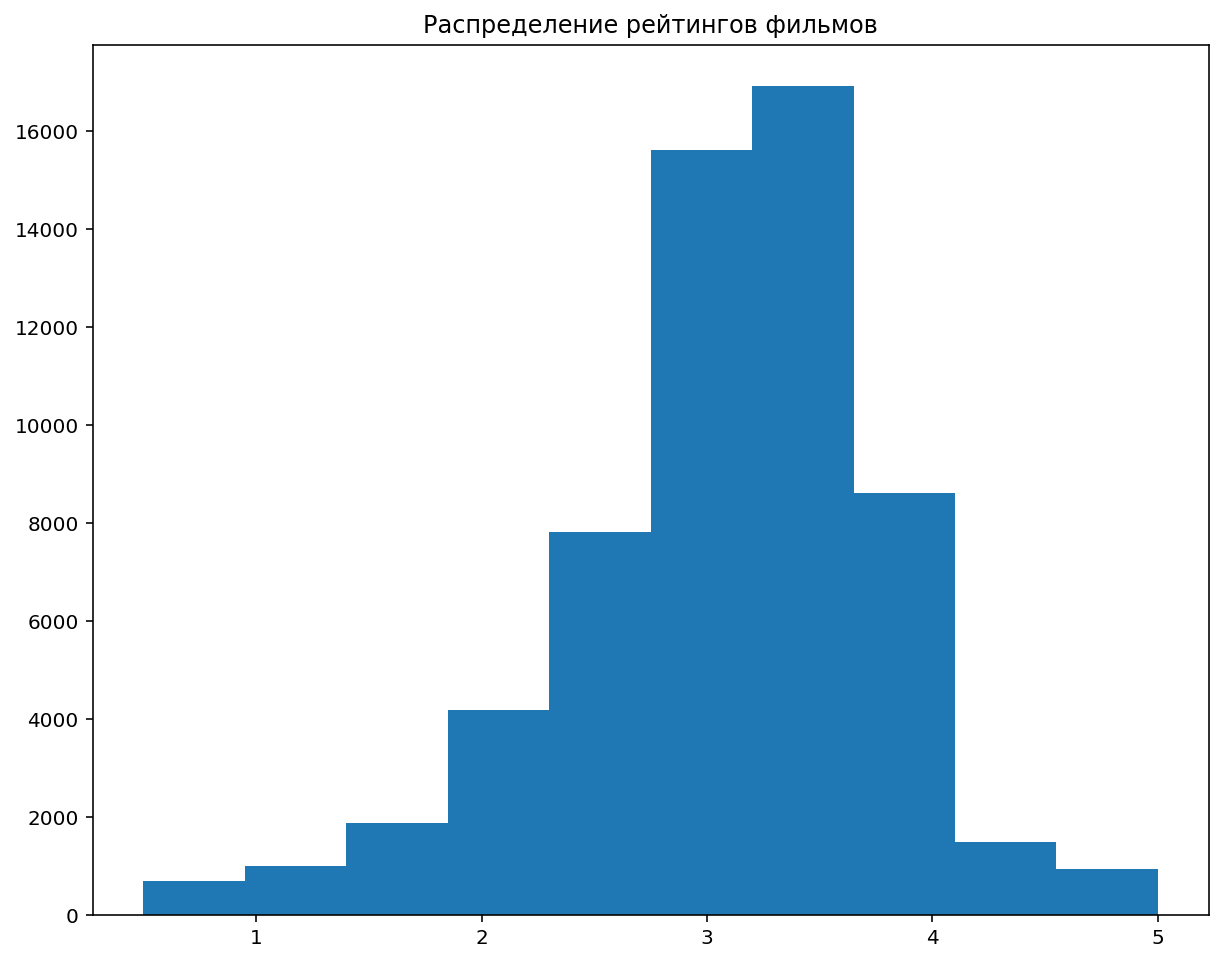

In [168]:
plt.figure(figsize=(10, 8))
plt.title('Распределение рейтингов фильмов')
plt.hist(mean_ratings)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [214]:
num_ratings = ratings\
              .map(lambda r: (r.movie_id, 1))\
              .reduceByKey(lambda a, b: a + b)\
              .map(lambda x: x[1])

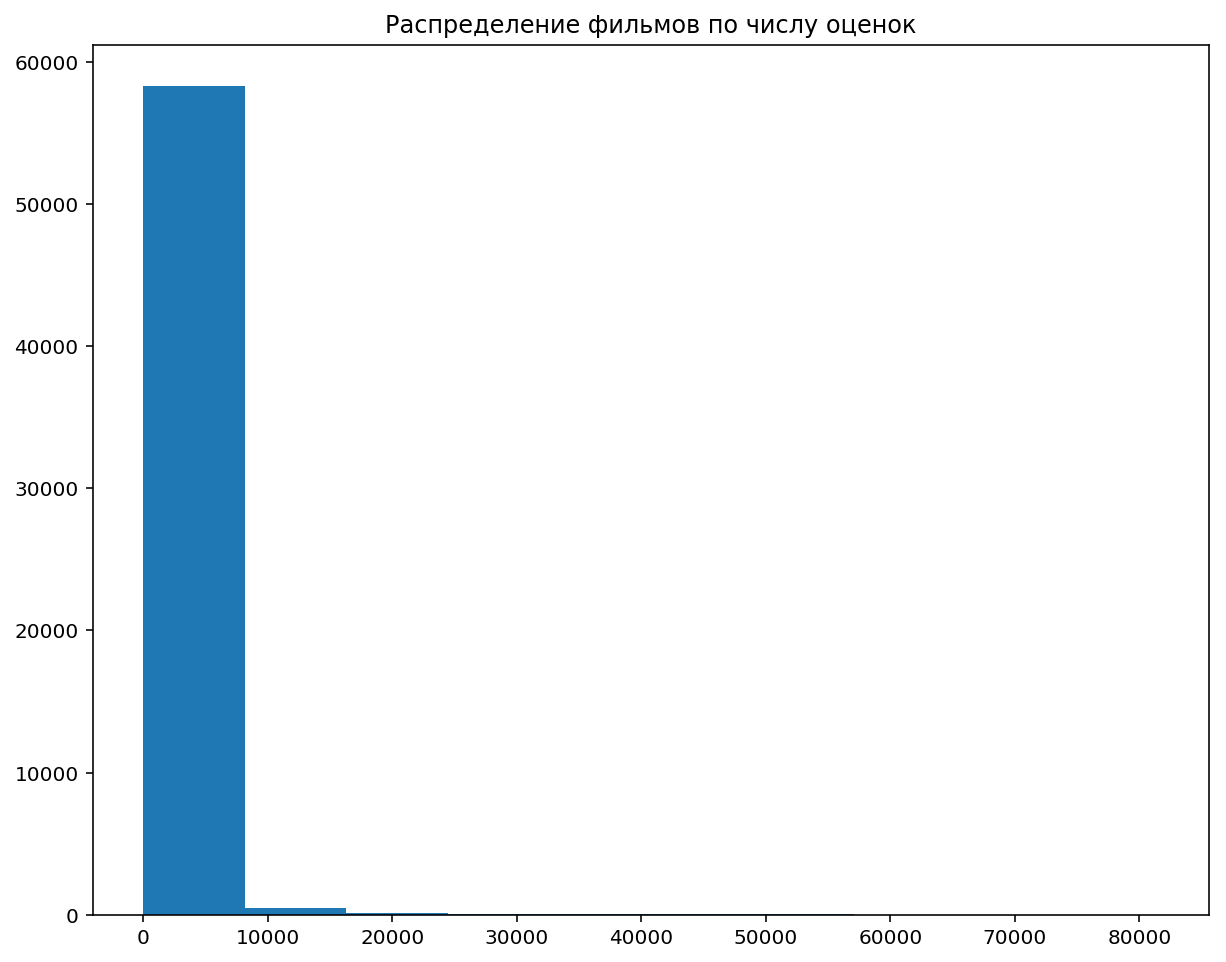

In [212]:
plt.figure(figsize=(10, 8))
plt.title('Распределение фильмов по числу оценок')
plt.hist(num_ratings.collect())
plt.show()

Давайте посмотрим на фильмы, у которых не слишком большое и не слишком маленькое число оценок (<1000 и больше 100)

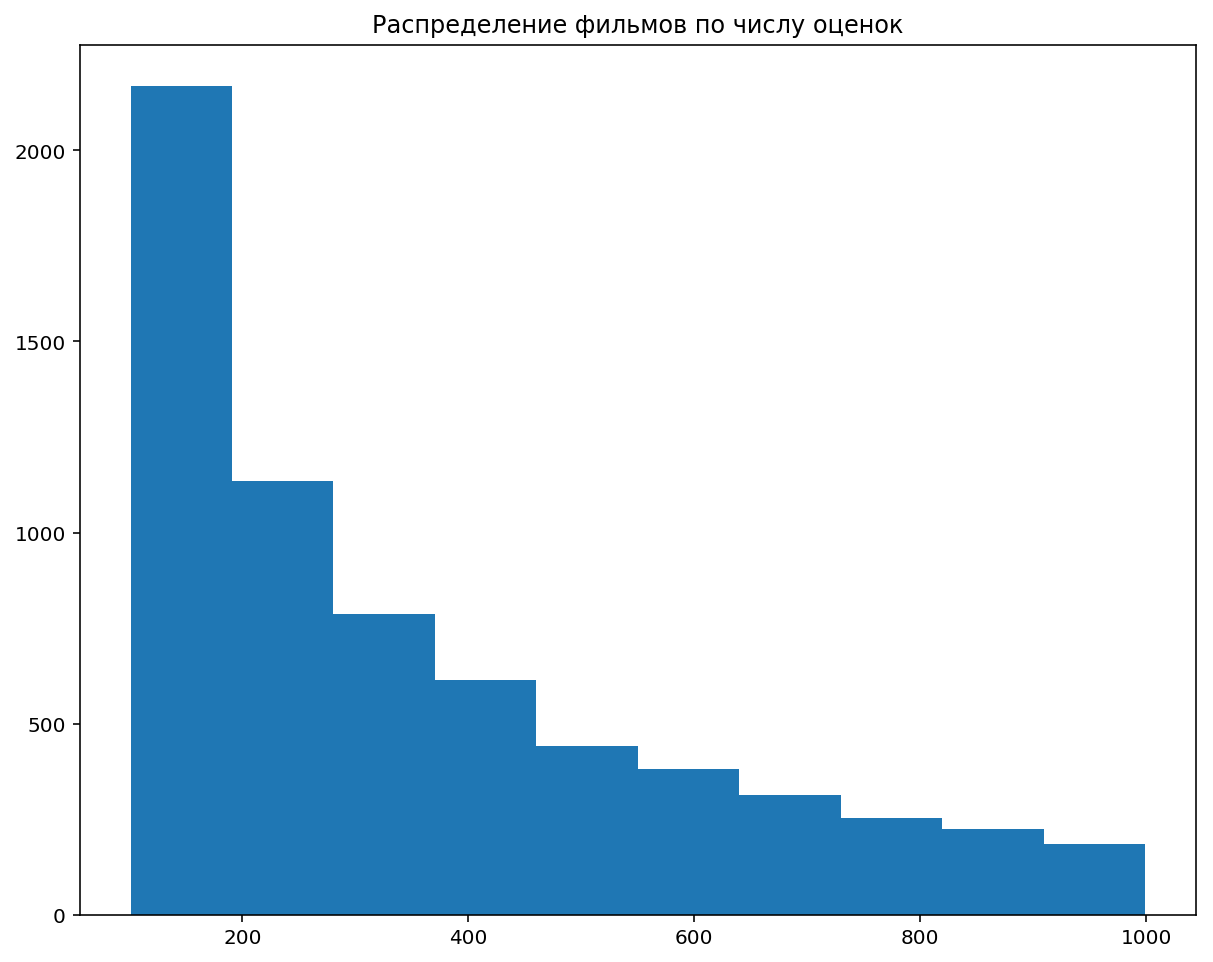

In [215]:
plt.figure(figsize=(10, 8))
plt.title('Распределение фильмов по числу оценок')
plt.hist(num_ratings.filter(lambda x: x < 1000 and x > 100).collect())
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [201]:
movies = sc.textFile(MOVIES_PATH)

In [202]:
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [207]:
movies\
    .map(lambda s: s.split(','))\
    .filter(lambda arr: arr[0].isdigit())\
    .map(lambda x: x[-1].split('|')).take(10)

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy'],
 ['Action', 'Crime', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Children'],
 ['Action'],
 ['Action', 'Adventure', 'Thriller']]

In [250]:
all_genres = movies\
            .map(lambda s: s.split(','))\
            .filter(lambda arr: arr[0].isdigit())\
            .map(lambda x: x[-1].split('|'))\
            .flatMap(lambda x: x)\
            .filter(lambda x: x != '(no genres listed)')

In [251]:
counts = all_genres.countByValue()

In [252]:
genres, counts = zip(*sorted(list(counts.items()), key=lambda x: -x[1]))

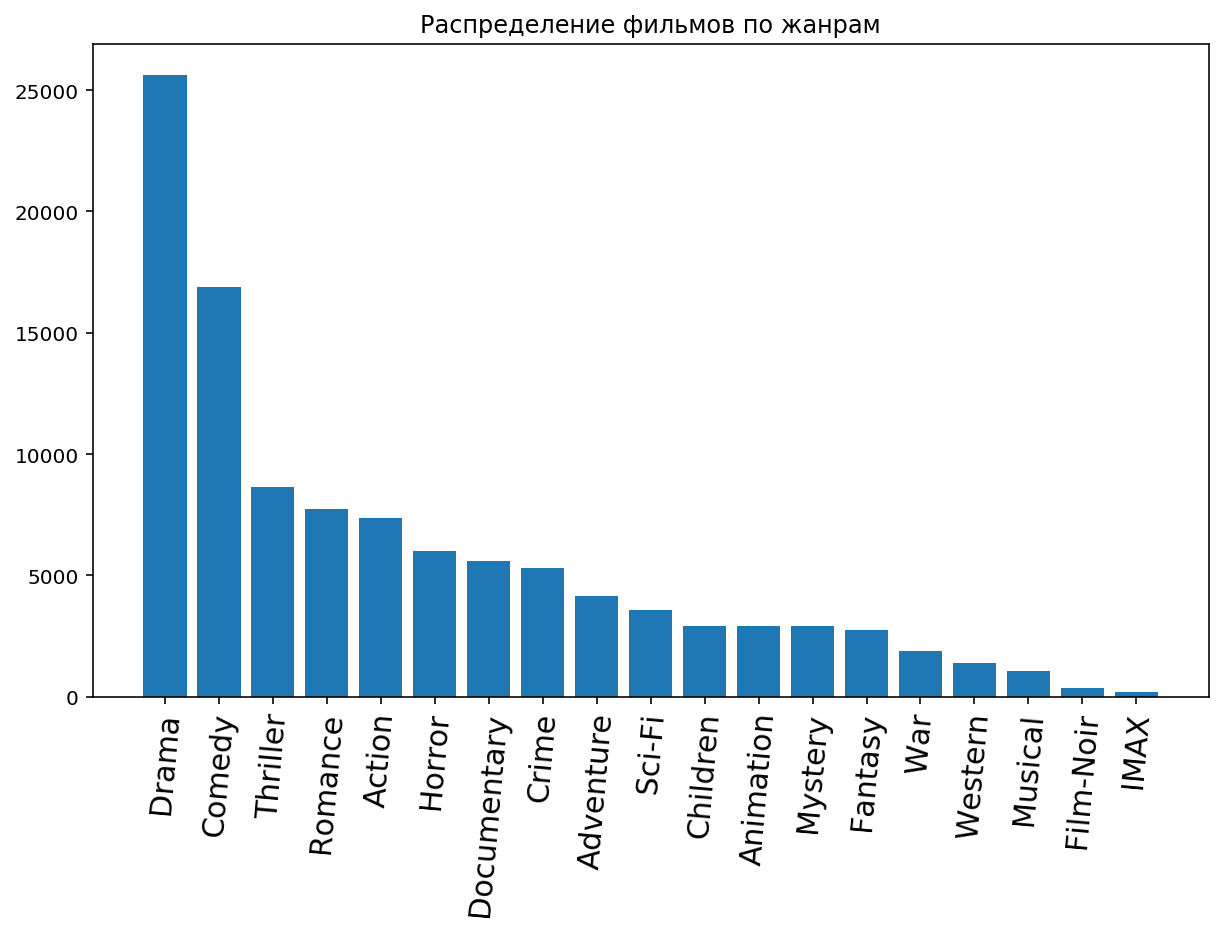

In [255]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genres, counts, align="center")
plt.title('Распределение фильмов по жанрам')
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [383]:
ratings = sc.textFile(RATINGS_PATH)
movies = sc.textFile(MOVIES_PATH)
links = sc.textFile(LINKS_PATH)
tmdb = sc.textFile(TMDB_PATH)

In [404]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [358]:
links.take(2)

['movieId,imdbId,tmdbId', '1,0114709,862']

In [374]:
tmdb2id = links\
        .map(lambda s: s.split(','))\
        .filter(lambda arr: arr[0].isdigit() and arr[2].isdigit())\
        .map(lambda x: (int(x[2]), int(x[0])))

In [414]:
tmdb = tmdb\
       .map(lambda s: json.loads(s))\
       .filter(lambda x: 'id' in x)

#### Про Тома Хэнкса

In [415]:
def leave_Tom_Hanks(cast_list):
    for character in cast_list:
        if character['id'] == 31 and character['name'] == 'Tom Hanks': # на всякий случай
            return True
    return False

In [416]:
tom_hanks_movies_tmdb = tmdb\
                        .map(lambda x: (int(x['id']), x['casts']['cast']))\
                        .filter(lambda x: leave_Tom_Hanks(x[1]))\
                        .map(lambda x: (x[0], 0))

In [417]:
tom_hanks_movies = tom_hanks_movies_tmdb.join(tmdb2id).map(lambda x: (x[1][1], 0))

In [418]:
tom_hanks_movies.join(movies).map(lambda x: (x[0], x[1][1][1])).collect()

[(539, 'Sleepless in Seattle (1993)'),
 (581, '"Celluloid Closet'),
 (117684, 'Elvis Has Left the Building (2004)'),
 (2072, '"\'burbs'),
 (2100, 'Splash (1984)'),
 (183043, 'Every Time We Say Goodbye (1986)'),
 (3255, '"League of Their Own'),
 (105504, 'Captain Phillips (2013)'),
 (106022, 'Toy Story of Terror (2013)'),
 (73472, 'Shooting War (2000)'),
 (107352, 'Killing Lincoln (2013)'),
 (1, 'Toy Story (1995)'),
 (132070, 'And the Oscar Goes To... (2014)'),
 (3130, 'Bonfire of the Vanities (1990)'),
 (4012, 'Punchline (1988)'),
 (4677, 'Turner & Hooch (1989)'),
 (54272, '"Simpsons Movie'),
 (87522, 'Larry Crowne (2011)'),
 (115879, 'Toy Story Toons: Small Fry (2011)'),
 (8884, '"Man with One Red Shoe'),
 (78499, 'Toy Story 3 (2010)'),
 (160980, 'Sully (2016)'),
 (178529, 'Mazes and Monsters (1982)'),
 (195063, 'Magnificent Desolation: Walking on the Moon (2005)'),
 (180497, 'The Post (2017)'),
 (2375, '"Money Pit'),
 (2424, "You've Got Mail (1998)"),
 (201588, 'Toy Story 4 (2019)'),

#### актеры, снявшиеся в наибольшем количестве фильмов

In [429]:
film2act = tmdb\
           .map(lambda x: (int(x['id']), x['casts']['cast']))\
           .flatMapValues(lambda x: (character['name'] for character in x))

In [448]:
film2act\
.map(lambda x: (x[1], 1))\
.reduceByKey(lambda a, b: a + b)\
.sortBy(lambda x: x[1], ascending=False).take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [521]:
tmdb2year = tmdb\
            .filter(lambda x: x['release_date'][:4].isdigit())\
            .map(lambda x: (int(x['id']), int(x['release_date'][:4])))

In [529]:
movie2year = tmdb2year\
                .join(tmdb2id)\
                .map(lambda x: (x[1][1], x[1][0]))

In [532]:
movie2year.take(10)

[(100595, 2011),
 (51933, 2007),
 (147308, 2008),
 (174261, 1909),
 (8921, 1955),
 (187777, 1972),
 (6770, 2003),
 (148805, 2014),
 (159692, 2008),
 (206785, 2016)]

In [533]:
movie_genre_pairs = movies\
                    .map(lambda s: s.split(','))\
                    .filter(lambda arr: arr[0].isdigit())\
                    .map(lambda x: (int(x[0]), x[-1].split('|')))\
                    .flatMapValues(lambda x: x)

In [536]:
movie_genre_pairs.take(10)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy'),
 (2, 'Adventure'),
 (2, 'Children'),
 (2, 'Fantasy'),
 (3, 'Comedy'),
 (3, 'Romance')]

In [543]:
genre_year_pairs = movie_genre_pairs\
                    .join(movie2year)\
                    .map(lambda x: x[1])\
                    .filter(lambda x: x[0] != '(no genres listed)')

In [544]:
genre_year_pairs.take(10)

[('Comedy', 2015),
 ('Horror', 2015),
 ('Drama', 2007),
 ('Romance', 2007),
 ('Horror', 2001),
 ('Comedy', 1995),
 ('Romance', 1995),
 ('Drama', 2016),
 ('Documentary', 2009),
 ('Drama', 1966)]

In [550]:
genre_year_pairs\
                .map(lambda x: ((x[1], x[0]), 1)).take(10)

[((2015, 'Comedy'), 1),
 ((2015, 'Horror'), 1),
 ((1972, 'Comedy'), 1),
 ((1972, 'Horror'), 1),
 ((2001, 'Horror'), 1),
 ((1995, 'Comedy'), 1),
 ((1995, 'Romance'), 1),
 ((1934, 'Romance'), 1),
 ((1934, 'War'), 1),
 ((2009, 'Documentary'), 1)]

In [554]:
genre_year_pairs\
                .map(lambda x: ((x[1], x[0]), 1)).c

106228

In [555]:
year_genre_count = genre_year_pairs\
                    .map(lambda x: ((x[1], x[0]), 1))\
                    .reduceByKey(lambda a, b: a + b)

In [556]:
year_genre_count.take(10)

[((2001, 'Documentary'), 84),
 ((1947, 'Musical'), 9),
 ((1977, 'Animation'), 23),
 ((1951, 'Drama'), 125),
 ((1976, 'Children'), 23),
 ((1921, 'Crime'), 1),
 ((1983, 'Animation'), 19),
 ((1977, 'Documentary'), 20),
 ((1981, 'Romance'), 45),
 ((1908, 'Drama'), 2)]

In [557]:
year_genre_count.map(lambda x: (x[0][0], (x[0][1], x[1]))).take(10)

[(2001, ('Documentary', 84)),
 (1947, ('Musical', 9)),
 (1977, ('Animation', 23)),
 (1951, ('Drama', 125)),
 (1976, ('Children', 23)),
 (1921, ('Crime', 1)),
 (1983, ('Animation', 19)),
 (1977, ('Documentary', 20)),
 (1981, ('Romance', 45)),
 (1908, ('Drama', 2))]

In [574]:
year2genres_counts = year_genre_count\
                    .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                    .reduceByKey(lambda a, b: a + b).collect()

In [584]:
genres2years_counts = year_genre_count\
                        .map(lambda x: (x[0][1], [(x[0][0], x[1])]))\
                        .reduceByKey(lambda a, b: a + b).collect()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [507]:
tmdb2money = tmdb\
             .filter(lambda x: x['revenue'] > 0 and x['budget'] > 0)\
             .map(lambda x: (int(x['id']), (x['revenue'], x['budget'])))

In [508]:
tmdb2money.take(2)

[(862, (373554033, 30000000)), (8844, (262797249, 65000000))]

In [509]:
tmdb2money.join(tmdb2id).take(10)

[(5, ((4257354, 4000000), 18)),
 (25, ((96889998, 72000000), 40278)),
 (35, ((527068851, 75000000), 54272)),
 (426030, ((15500000, 7154497), 184741)),
 (55, ((20908467, 2000000), 4235)),
 (65, ((242875078, 41000000), 5810)),
 (70, ((216763646, 30000000), 30707)),
 (75, ((101371017, 70000000), 1391)),
 (80, ((15992615, 2700000), 8638)),
 (32850, ((1129000, 1290000), 33113))]

In [510]:
movie2money = tmdb2money.join(tmdb2id).map(lambda x: (x[1][1], x[1][0]))

In [511]:
movie_genre_pairs = movies\
                    .map(lambda s: s.split(','))\
                    .filter(lambda arr: arr[0].isdigit())\
                    .map(lambda x: (int(x[0]), x[-1].split('|')))\
                    .flatMapValues(lambda x: x)

In [512]:
movie_genre_pairs.join(movie2money).take(2)

[(7, ('Comedy', (53672080, 58000000))), (7, ('Romance', (53672080, 58000000)))]

In [513]:
movie_genre_pairs.join(movie2money).map(lambda x: (x[1][0], (*x[1][1], 1))).take(2)

[('Comedy', (53672080, 58000000, 1)), ('Romance', (53672080, 58000000, 1))]

In [514]:
genre2ROI = movie_genre_pairs\
            .join(movie2money)\
            .map(lambda x: x[1])\
            .filter(lambda x: x[0] != '(no genres listed)')\
            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
            .map(lambda x: (x[0], x[1][0] / x[1][1]))

In [515]:
genres, rois = zip(*sorted(genre2ROI.collect(), key=lambda x: -x[1]))

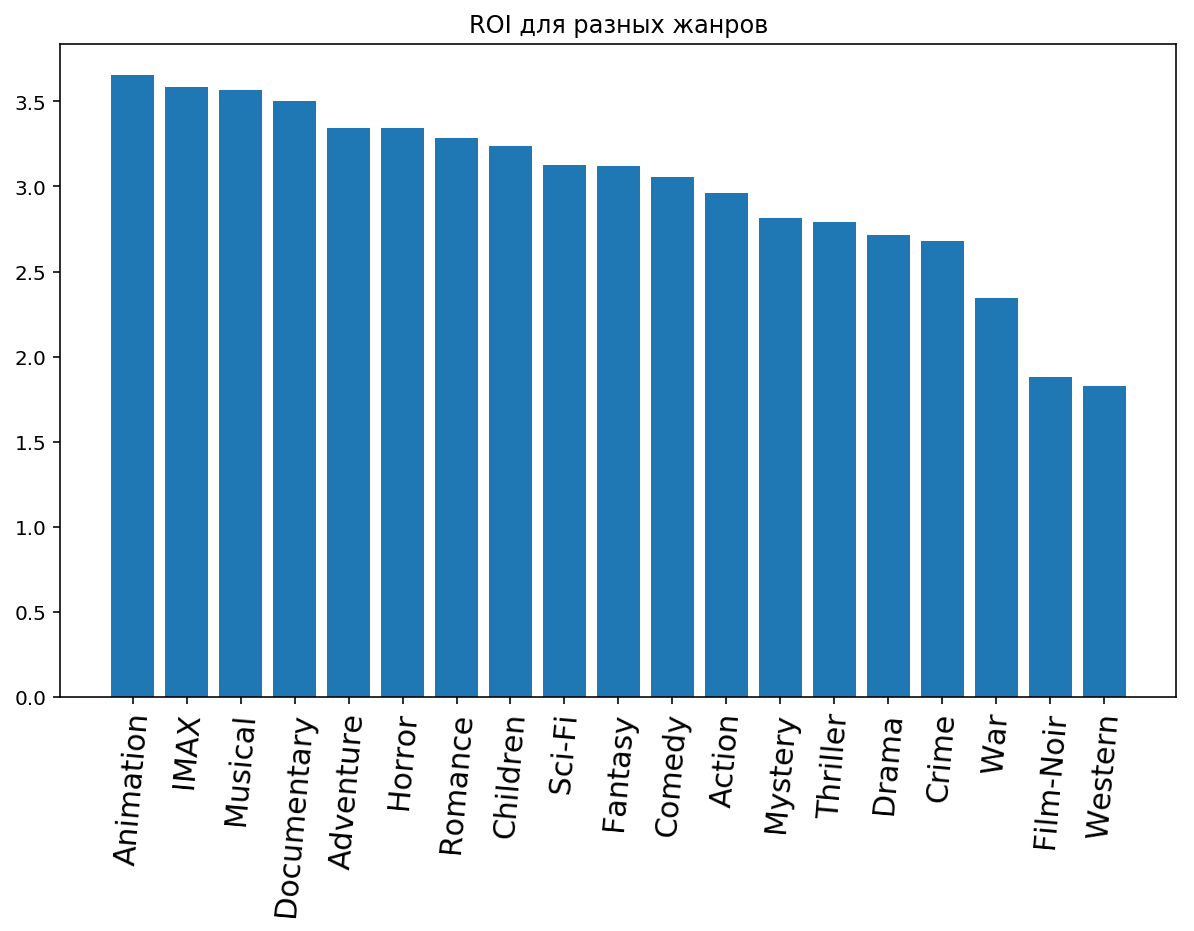

In [516]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genres, rois, align="center")
plt.title('ROI для разных жанров')
plt.show()